In [1]:
source('PTrees.R')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

corrplot 0.84 loaded

Attaching package: ‘lubridate’

The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from ‘package:base’:

    date


Attaching package: ‘purrr’

The following object is masked from ‘package:data.table’:

    transpose



### Documentation
exp_mech(domain, util, eps, sens=1)    
get_ent(matrix) - entropy computed on rows  
cond_eval_num(xs, ys, uti=get_ent, eps=0, min=0, max=0)  
cond_eval_fac(xs, ys, uti=get_ent)  
condeval(attr_name, data, range_bounds, ys):  
returns a list with (name, type, ent, split) attributes  
laplacian(epsilon, length=1, sensitivity=1) - variance 2(s^2/e^2)  
claplace(x, lambda) - CDF of Laplace with variance 2/lambda^2 eval at x  
hist_noiser(vals, epsilon=0)  
dtree(data, depth=3)  
dt_private(data, budget, d=3)  
predict(tree, dataset, y_levels)  
prune_tree(tree, y_levels)  
test_private(tree, data, y_name, train_test_cutoff=0.8)

In [2]:
source('Datasets.R')
library(parallel)

In [3]:
set.seed(12345)

In [4]:
decision_tree_sep <- function(data, range_bounds, pred, attrs, node, eps, d){
    p <- get(pred, data)
    if(length(attrs) == 0 || d <= 0){
        m <- data.frame(table(p))
        node$counts <-  hist_noiser(m$Freq, eps) #m$Freq+laplacian(eps, nrow(m))
        idx <- which.max(node$counts)
        guess <- m$p[idx]
        node$guess <- guess
        node$name <- paste(node$name, guess, sep=';')
        return()
    }
    atp <- lapply(attrs, function(name) cond_eval(name, data, range_bounds, p))
    best_attr <- exp_mech(atp, sapply(atp, function(x) -x$ent), eps, ent_util$sens)
    node$name <- paste(node$name, best_attr$name, sep=';')
    node$branch <- node$name
    ba <- best_attr$name
    nl <- attrs[attrs!= ba]
    if(best_attr$type == 'numeric'){
        s1 <- get(ba, data) < best_attr$split
        s <- best_attr$split
        decision_tree_sep(data[s1,], range_bounds, pred, nl, node$AddChild(paste("<=", s, sep='')), eps, d-1)
        decision_tree_sep(data[!s1,], range_bounds, pred, nl, node$AddChild(paste(">", s, sep='')), eps, d-1)
        node$pars <- c(function(d){return(d <= s)}, function(d){return(d > s)})
    }else if(best_attr$type == 'factor'){
        p <- get(ba, data)
        dec_f <- lapply(best_attr$split, equality)
        for(a in best_attr$split){
            decision_tree_sep(data[p == a,], range_bounds, pred, nl, node$AddChild(a), eps, d-1)
        }
        node$pars <- dec_f
    }
    node$attr <- ba
}
#Returns a private decision tree (call this one)
dt_sep <- function(db, B, d=3){
    eps <- B/(d+2)
    dt_p <- Node$new('')
    nrow <- hist_noiser(nrow(data), eps)
    sizes <- lapply(db$data, function(col){
        if(class(col) == 'numeric')
            return(2)
        return(length(levels(col)))
    })
    t <- sizes[db$x_names] %>% reduce(`max`)
    C <- get(db$y_names, sizes)
    d_vanish <- as.integer(log(B*nrow / (sqrt(2) * C*t)) / log(2))+1
    d <- min(d, d_vanish)
    decision_tree_sep(db$data, db$rng, db$y_names, db$x_names, dt_p, eps, d)
    return(dt_p)
}

In [92]:
generate_data_helper <- function(attr_names, class, attr_sizes, cur_val, nrow, d_continue, p_stop){
    attr_sz <- 0
    attr <- 0
    if(attr_names %>% length > 0){
        attr <- sample(attr_names, 1)
        attr_sz <- get(attr, attr_sizes)
    }
    if(d_continue <= 0 && runif(1) < p_stop || attr_sz > nrow || attr==0){
        cur_val[class] <- runif(1, max=class %>% get(attr_sizes)) %>% as.integer
        df <- lapply(cur_val, function(x) rep(x, nrow)) %>% data.frame
        L <- lapply(attr_names, function(x) runif(nrow, max=x %>% get(attr_sizes)) %>% as.integer)
        names(L) <- attr_names
        df2 <- data.frame(L)
        if(length(df2) > 0)
            df <- cbind(df, df2)
        return(df)
    }
    D <- data.frame()
    attr_names <- attr_names[attr_names != attr]
    r <- 1+rmultinom(1, nrow-attr_sz, integer(attr_sz)+1)
    for(i in 1:attr_sz){
        c <- cur_val
        c[attr] = i-1
        D <- rbind(D, generate_data_helper(attr_names, class, attr_sizes, c, r[i], d_continue-1, p_stop))
    }
    return(D)
}
generate_data <- function(attr_names, class, attr_sizes, nrow, d_continue, p_stop=0.3){
    D <- generate_data_helper(attr_names, class, attr_sizes, list(), nrow, d_continue, p_stop)
    D <- D[sample(1:nrow(D), nrow(D)), ] %>% lapply(function(x) as.factor(x)) %>% data.frame
    return(list(data=D, x_names=attr_names, y_names=class, rng=NA))
}                                                    

In [127]:
decision_tree_rand <- function(data, range_bounds, pred, attrs, node, eps, d, pstop=0.3){
    p <- get(pred, data)
    if(length(attrs) == 0 || d <= 0){
        m <- data.frame(table(p))
        node$counts <-  hist_noiser(m$Freq, eps) #m$Freq+laplacian(eps, nrow(m))
        idx <- which.max(node$counts)
        guess <- m$p[idx]
        node$guess <- guess
        node$name <- paste(node$name, guess, sep=';')
        return()
    }
    name <- sample(attrs, 1)
    best_attr <- cond_eval(name, data, range_bounds, p)
    node$name <- paste(node$name, best_attr$name, sep=';')
    node$branch <- node$name
    ba <- best_attr$name
    nl <- attrs[attrs!= ba]
    if(best_attr$type == 'numeric'){
        s1 <- get(ba, data) < best_attr$split
        s <- best_attr$split
        decision_tree_rand(data[s1,], range_bounds, pred, nl, node$AddChild(paste("<=", s, sep='')), eps, d-1)
        decision_tree_rand(data[!s1,], range_bounds, pred, nl, node$AddChild(paste(">", s, sep='')), eps, d-1)
        node$pars <- c(function(d){return(d <= s)}, function(d){return(d > s)})
    }else if(best_attr$type == 'factor'){
        p <- get(ba, data)
        dec_f <- lapply(best_attr$split, equality)
        for(a in best_attr$split){
            decision_tree_rand(data[p == a,], range_bounds, pred, nl, node$AddChild(a), eps, d-1)
        }
        node$pars <- dec_f
    }
    node$attr <- ba
}
#Returns a private decision tree (call this one)
dt_rand <- function(db, B, d=5, pstop=0.3){
    dt_p <- Node$new('')
    decision_tree_rand(db$data, db$rng, db$y_names, db$x_names, dt_p, B, d, pstop)
    return(dt_p)
}

In [137]:
attr_names <- LETTERS[1:10]
class <- 'P'
attr_sizes <- list(A=3, B=2, C=5, D=4, E=2, F=2, G=2, H=3, I=5, J=4, P=3)

In [8]:
split <- function(D, cutoff=0.8){
    cutoff <- as.integer(nrow(D$data)*cutoff)
    D1 <- D
    D2 <- D
    D1$data <- D$data[1:cutoff, ]
    D2$data <- D$data[(cutoff+1):nrow(D$data), ]
    return(list(train=D1, test=D2))
}
test <- function(D, B, dep, dt_gen){
    dt <- dt_gen(D$train, B, dep)
    ys <- get(D$test$y_names, D$test$data)
    default <- ys[1]
    p <- predict(dt, D$test$data, default)
    return(sum(p == ys) / length(ys))
}

In [10]:
dt_priv_prune <- function(...) {
    dt <- dt_private(...)
    prune_tree(dt, get(T$test$y_names, T$test$data) %>% levels)
    return(dt)
}

In [113]:
get_data <- function(T, eps_test, d=5){
    G1 <- mcmapply(function(...) sapply(eps_test, function(e) {test(T, e, d, dt_sep)}), 1:10)
    G2 <- mcmapply(function(...) sapply(eps_test, function(e) {test(T, e, d, dt_priv_prune)}), 1:10)
    G3 <- mcmapply(function(...) sapply(eps_test, function(e) {test(T, e, d, dt_rand)}), 1:10)
    G4 <- mcmapply(function(...) sapply(eps_test, function(e) {test(T, e, d, dt_private)}), 1:10)
    L <- test(T, 0, 5, dtree)
    DF <- rbind(data.frame(eps=eps_test, performance=rowMeans(G1), advice='Weak Size Advice'),
                data.frame(eps=eps_test, performance=rowMeans(G2), advice='Strong Size Advice, Prune'),
                data.frame(eps=eps_test, performance=rowMeans(G3), advice='No Size Advice, Random Choice'), 
                data.frame(eps=eps_test, performance=rowMeans(G4), advice='Strong Size Advice'))
    G <- ggplot(DF, aes(x=eps, y=performance, color=advice))+geom_line()+geom_hline(yintercept=test(T, 0, d, dtree))
    return(list(data=DF, graph=G))
}

In [139]:
set.seed(12345)
eps_test <- c(0.5, 1:10)
D <- generate_data(attr_names, class, attr_sizes, 6000, 3, 0.5)
T <- split(D)
results <- get_data(T, eps_test, 5)

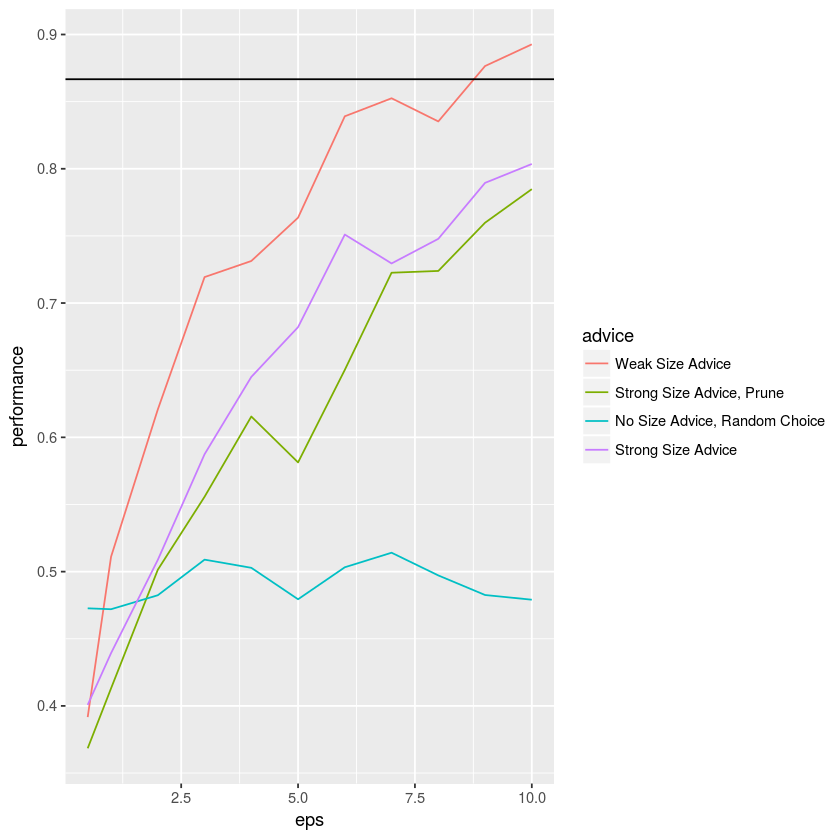

In [131]:
results$graph

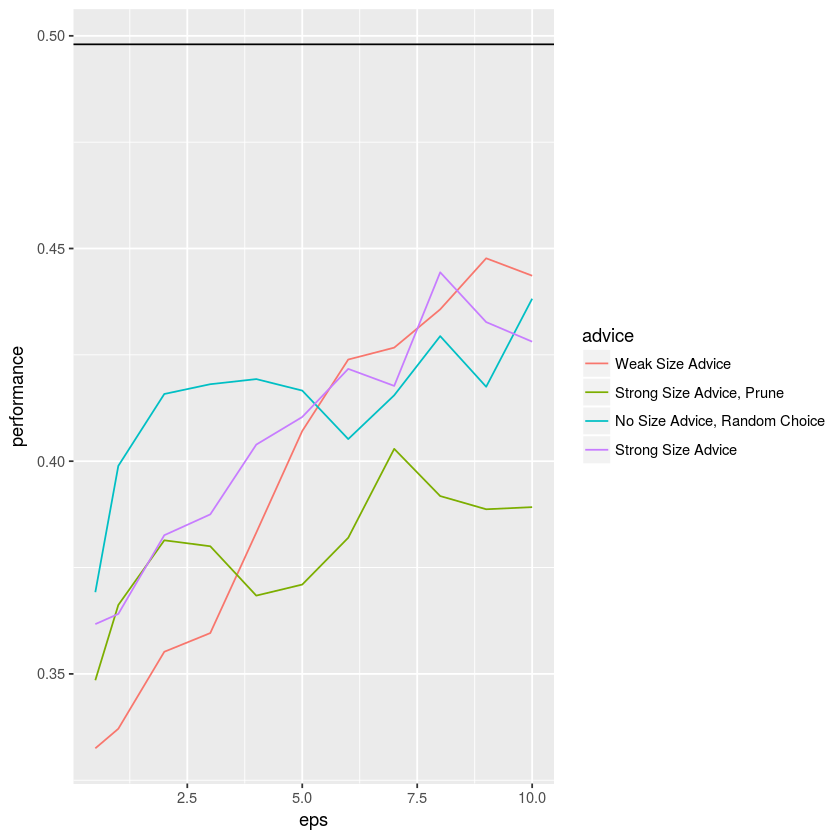

In [141]:
set.seed(12345)
T2 <- generate_data(attr_names, class, attr_sizes, 2000, 5, 1.0) %>% split(0.5)
results2 <- get_data(T2, eps_test, 5)
results2$graph
#Why is it performing badly?

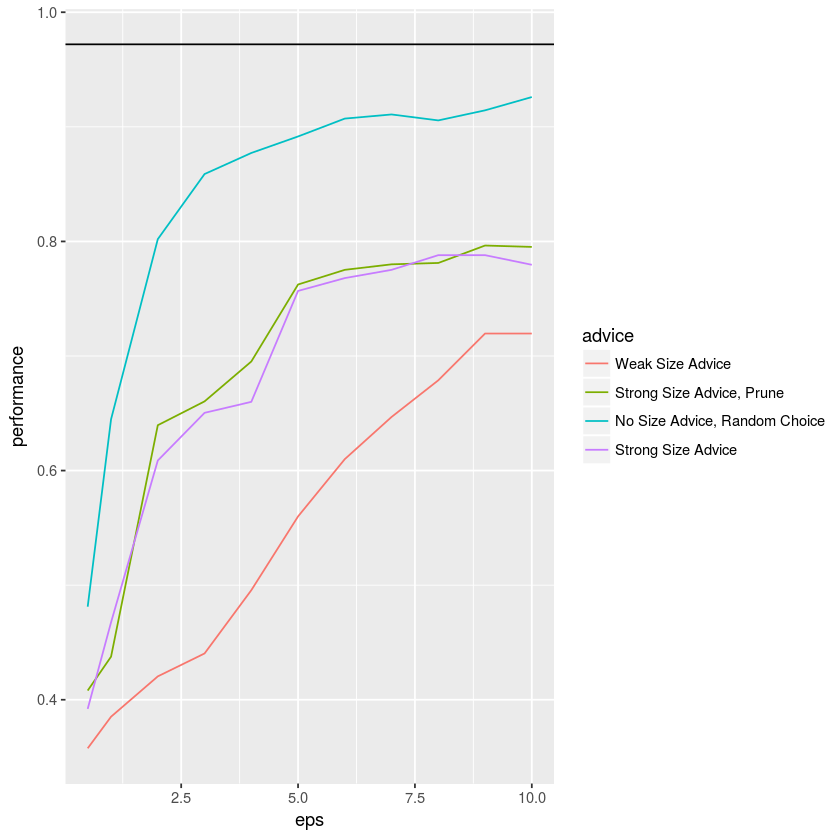

In [164]:
set.seed(12345)
T3 <- generate_data(c('A', 'B', 'C', 'D'), 'P', attr_sizes, 500, 0.5) %>% split(0.5)
results3 <- get_data(T3, eps_test)
results3$graph

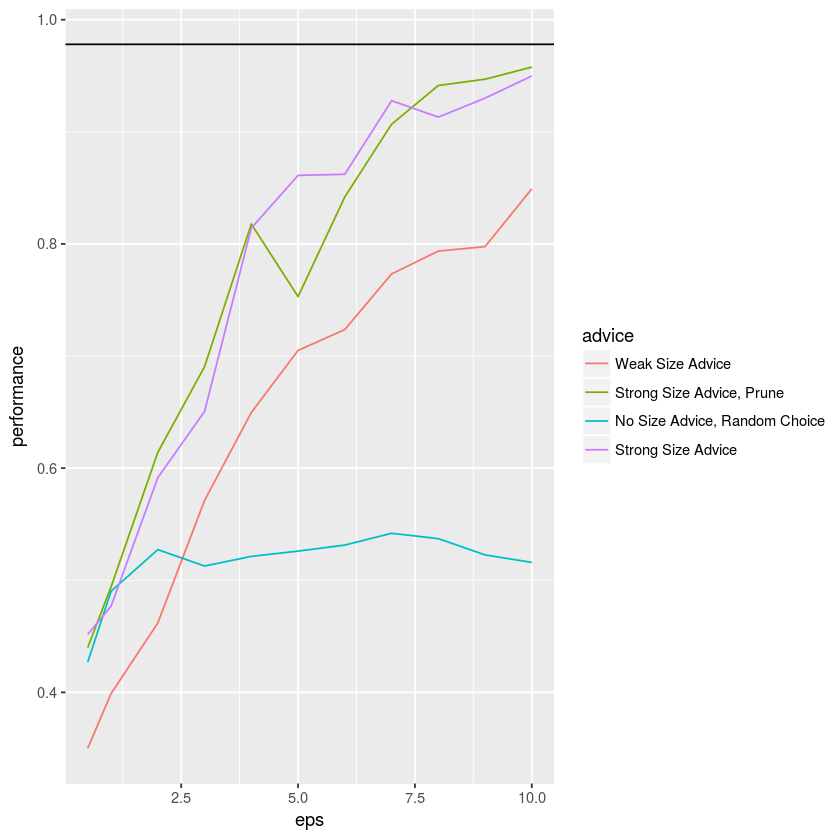

In [165]:
set.seed(12345)
T4 <- generate_data(attr_names, class, attr_sizes, 2000, 2, 0.5) %>% split(0.5)
results4 <- get_data(T4, eps_test)
results4$graph

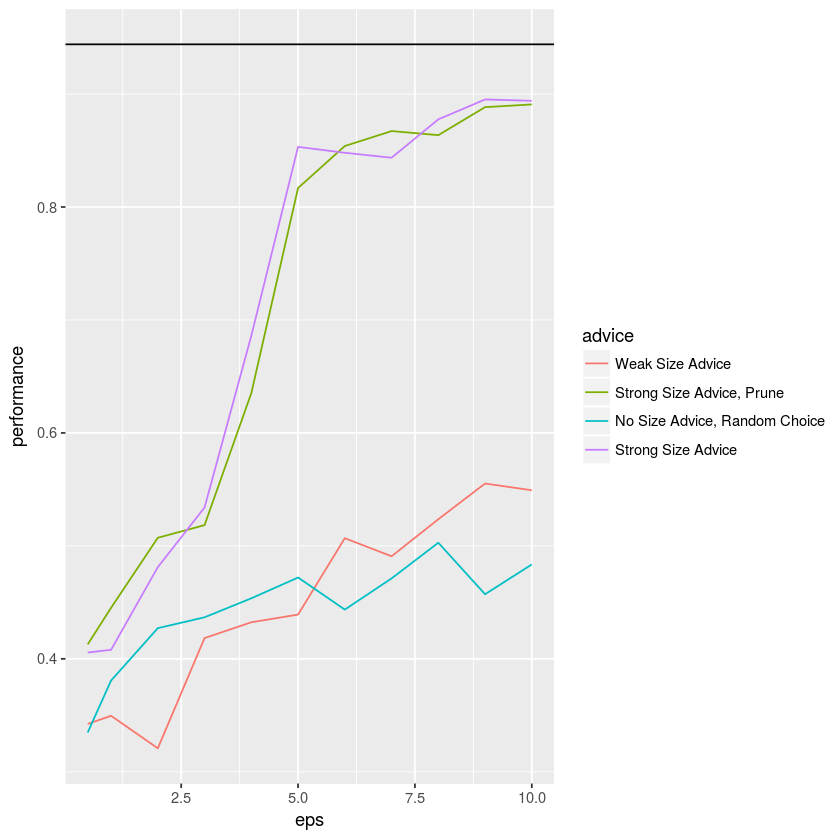

In [135]:
T5 <- generate_data(attr_names, class, attr_sizes, 500, 2, 0.5) %>% split(0.5)
results5 <- get_data(T5, eps_test)
results5$graph